### Reading,displaying and writing images

In [2]:
import tifffile as tf

d0 = r'./ExampleHuman/images/AS_09125_050116030001_D03f00d0.tif'
nuc = tf.imread(d0)

stacks = r'./ExampleHuman/images/cells.tif'
cells = tf.imread(stacks)

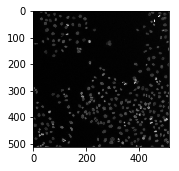

In [4]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(2.5, 2.5))
plt.imshow(cells[0,:,:], cmap="gray")
plt.show()

In [3]:

tf.imsave('./ExampleHuman/images/AS_09125_050116030001_D03f00d0_copy.tif', nuc)

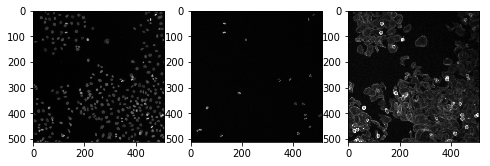

In [5]:
#plt.imshow(cells[2,:,:])
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cells[i-1,:,:],cmap="gray")
plt.show()

### Image data representation

<class 'numpy.ndarray'>
(512, 512)
(3, 512, 512)
[[8 8 8 8 8 8]
 [8 8 7 8 8 7]
 [9 8 8 8 8 8]]


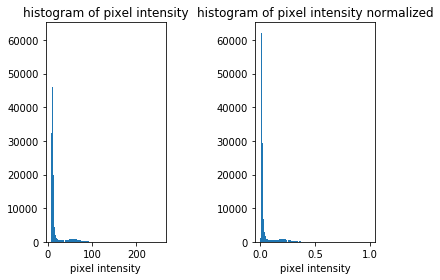

7 255
0.0 1.0


In [7]:
import numpy as np

print(type(nuc))
print(nuc.shape)
print(cells.shape)
print(nuc[0:3,0:6])

nuc_norm = np.interp(nuc, (nuc.min(), nuc.max()), (0,1))

fig, axes = plt.subplots(ncols=2)
ax0, ax1 = axes.flatten()
ax0.hist(nuc.ravel(), bins=256)
ax0.set_title("histogram of pixel intensity")
ax0.set_xlabel("pixel intensity")
ax1.hist(nuc_norm.ravel(), bins=256)
ax1.set_title("histogram of pixel intensity normalized")
ax1.set_xlabel("pixel intensity")
fig.tight_layout(w_pad=4)
plt.show()

print(nuc.min(), nuc.max())
print(nuc_norm.min(), nuc_norm.max())

### Color management

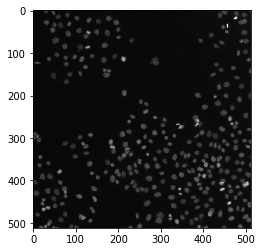

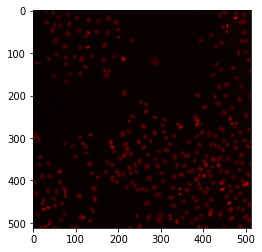

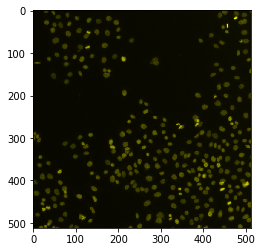

In [8]:
from skimage.color import gray2rgb
from skimage import img_as_float

rgb_nuc = gray2rgb(nuc)
plt.imshow(rgb_nuc)
plt.show()

# red channel
red = [1,0,0]
r_nuc = img_as_float(rgb_nuc) * red
plt.imshow(r_nuc)
plt.show()

# yellow channel
red = [1,1,0]
r_nuc = img_as_float(rgb_nuc) * red
plt.imshow(r_nuc)
plt.show()

### Manipulating images

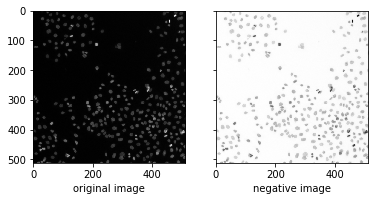

In [9]:
nuc_neg = nuc.max() - nuc
fig, axes = plt.subplots(ncols=2)
ax0, ax1 = axes.flatten()
ax0.imshow(nuc, cmap='gray')
ax0.set_xlabel("original image")
ax1.imshow(nuc_neg, cmap='gray')
ax1.set_xlabel("negative image")
plt.setp(ax1.get_yticklabels(), visible=False)
plt.show()

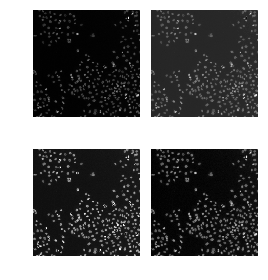

In [10]:
bright_nuc = nuc + 30
contrast_nuc = nuc * 2
gamma_nuc = nuc ** 0.5

fig, axes = plt.subplots(ncols=2, nrows=2)
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.imshow(nuc, cmap='gray')
ax1.imshow(bright_nuc, cmap='gray')
ax2.imshow(contrast_nuc, cmap='gray')
ax3.imshow(gamma_nuc, cmap='gray')
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
fig.tight_layout(w_pad=-15)
plt.show()

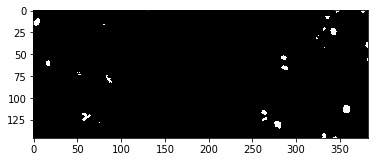

[[False False False ...  True  True False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [11]:
img_crop = nuc[366:512,58:441]
img_thresh = img_crop > 100
plt.imshow(img_thresh, cmap='gray')
plt.show()
print(img_thresh)

### spatial transformation

/home/cedric/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


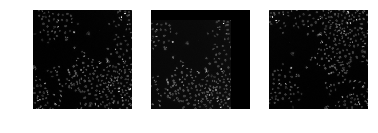

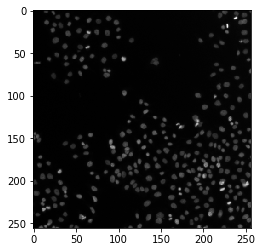

In [12]:
from skimage import transform as trf

translate = trf.SimilarityTransform(translation=(100,-50))

translated = trf.warp(nuc, translate)
rotated = trf.rotate(nuc, angle=90)
resized = trf.resize(nuc, (256,256))

fig, ax = plt.subplots(ncols=3)

ax[0].imshow(nuc, cmap=plt.cm.gray)
ax[1].imshow(translated, cmap=plt.cm.gray)
ax[2].imshow(rotated, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')
plt.show()

plt.imshow(resized, cmap=plt.cm.gray)
plt.show()

### Cell segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


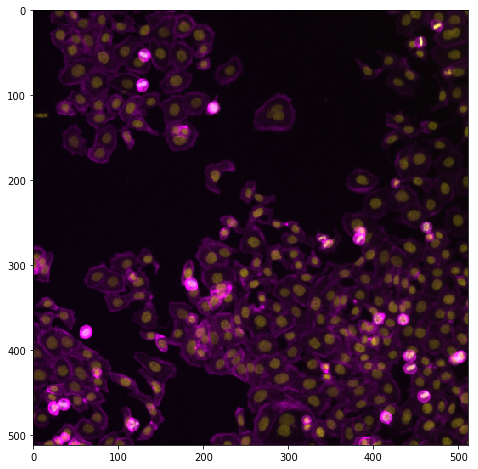

In [14]:
from skimage.color import gray2rgb, label2rgb
from skimage import restoration
from skimage.filters import threshold_otsu, sobel
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.morphology import dilation, disk
from skimage.segmentation import watershed, mark_boundaries
from skimage.measure import label, regionprops
from centrosome.propagate import propagate

d1 = r'./ExampleHuman/images/AS_09125_050116030001_D03f00d1.tif'
ph3 = tf.imread(d1)

d2 = r'./ExampleHuman/images/AS_09125_050116030001_D03f00d2.tif'
cell = tf.imread(d2)

cell_norm = np.interp(cell, (cell.min(), cell.max()), (0,1))
ph3_norm = np.interp(ph3, (ph3.min(), ph3.max()), (0,1))

nuc_rgb = gray2rgb(nuc_norm)
nuc_rgb = nuc_rgb * [1,1,0]
cell_rgb = gray2rgb(cell_norm)
cell_rgb = cell_rgb * [1,0,1]
ph3_rgb = gray2rgb(ph3_norm)
ph3_rgb = ph3_rgb * [0,0,1]

composite = nuc_rgb + cell_rgb + ph3_rgb
plt.figure(figsize=(8,8))
plt.imshow(composite)
plt.show()

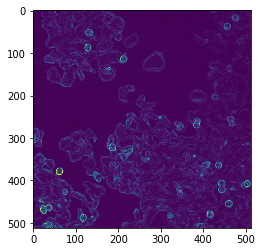

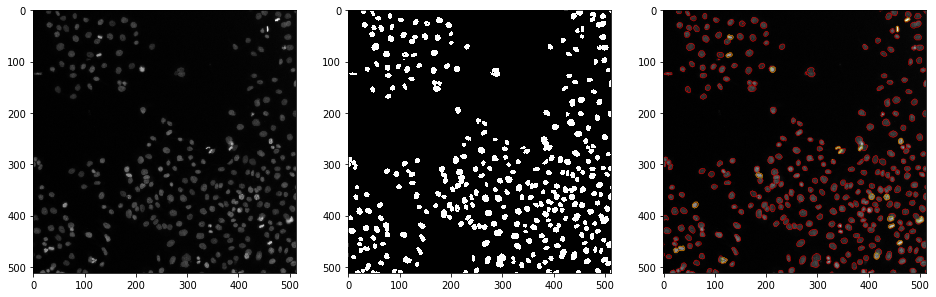

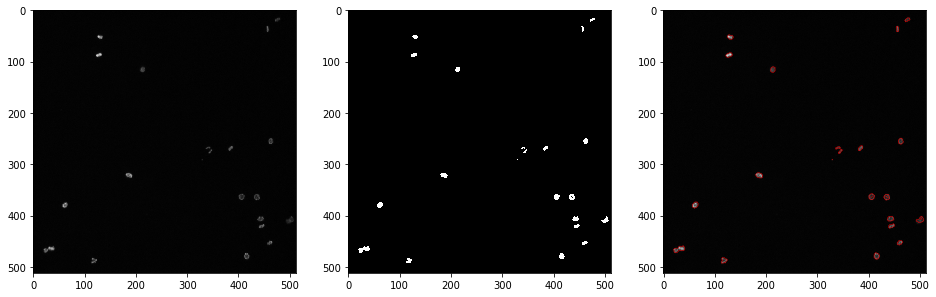

In [15]:
mask_nuc = np.zeros(nuc_norm.shape, dtype = bool)
mask_nuc[nuc_norm > threshold_otsu(nuc_norm)] = 1

mask_ph3 = np.zeros(ph3_norm.shape, dtype = bool)
mask_ph3[ph3_norm > threshold_otsu(nuc_norm)] = 1

fsobel = np.empty_like(cell_norm)
fsobel = sobel(cell_norm)

plt.imshow(fsobel)

fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(nuc_norm, cmap = 'gray')
ax[1].imshow(mask_nuc, cmap = 'gray')
ax[2].imshow(nuc_norm, cmap = 'gray') 
ax[2].contour(mask_nuc, colors = 'r', linewidths = 0.1)
ax[2].contour(mask_ph3, colors = 'y', linewidths = 0.1)
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(ph3_norm, cmap = 'gray')
ax[1].imshow(mask_ph3, cmap = 'gray')
ax[2].imshow(ph3_norm, cmap = 'gray') 
ax[2].contour(mask_ph3, colors = 'r', linewidths = 0.1)
plt.show()


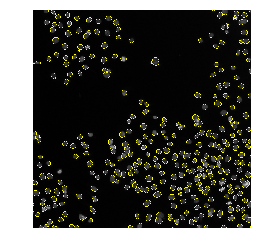

299
30658
21


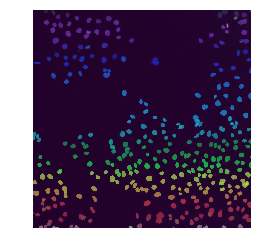

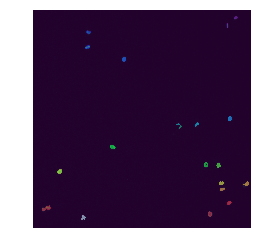

In [16]:
plt.imshow(mark_boundaries(nuc_norm, mask_nuc))
plt.axis('off')
plt.show()


markers_nuc = label(mask_nuc, connectivity=1, return_num=True)
print(markers_nuc[1])

print(np.count_nonzero(markers_nuc[0]))

markers_ph3 = label(mask_ph3, connectivity=1, return_num=True)
print(markers_ph3[1])

plt.imshow(nuc_norm)
plt.imshow(markers_nuc[0], cmap = "nipy_spectral", alpha = 0.5)

plt.axis('off')
plt.show()

plt.imshow(ph3_norm)
plt.imshow(markers_ph3[0], cmap = "nipy_spectral", alpha = 0.5)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


299


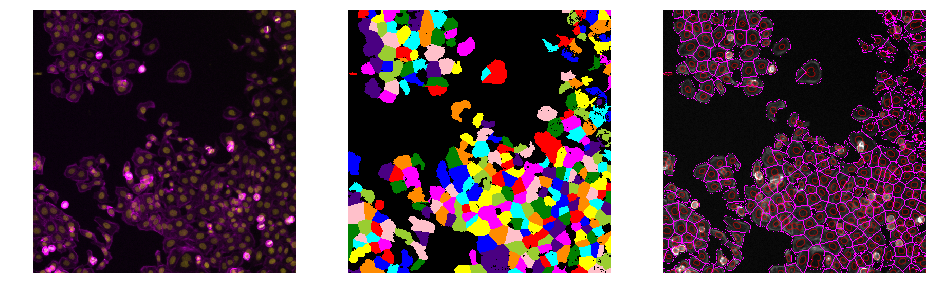

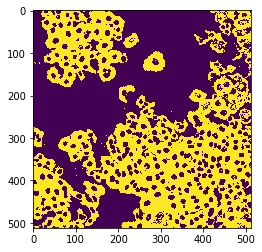

In [17]:
mask_cell = np.zeros(cell_norm.shape, dtype = bool)
mask_cell[cell_norm > threshold_otsu(cell_norm * 0.3)] = True

#cyto_seg = watershed(image=fsobel, markers=markers, compactness = 0.00001)
cell_seg,_ = propagate(image=fsobel, labels=markers_nuc[0], mask=mask_cell, weight=1)

labeled = label(cell_seg, return_num=True)

print(labeled[1])

fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(composite)
ax[1].imshow(label2rgb(labeled[0], bg_label=0))
ax[2].imshow(mark_boundaries(cell_norm, cell_seg, color=(1,0,1)))
ax[2].contour(mask_nuc, colors = 'r', linewidths = 0.1)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

cyto = np.logical_xor(mask_cell, mask_nuc)
plt.imshow(cyto)


### Extracting Quantitative Measurements

In [18]:
results = {"cell_id":[],
           "cell_mean":[]}

for cell_id in np.unique(cell_seg):
    cell_mask = cell_seg==cell_id
    
    results["cell_id"].append(cell_id.item())
    results["cell_mean"].append(np.mean(cell_norm[cell_mask]).item())
